In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [6]:
meters = pd.read_csv('combined_data.csv', parse_dates=True)
meters.head()

,Unnamed: 0,meter_id,w_timestamp,current,voltage,frequency,power_factor,energy,real_power,reactive_power,apparent_power,tita,hour,time_diff
0,0,OND023,2022-07-12 13:57:30.449294+00:00,0.79,210.1,50.1,0.75,NaN,0.124484,0.109785,0.165979,41.409622,14,0.009675
1,1,OND023,2022-07-12 13:58:42.793010+00:00,0.80,210.6,50.0,0.75,0.002539,0.126360,0.111439,0.168480,41.409622,14,0.009675
2,2,OND023,2022-07-12 14:00:28.080361+00:00,0.85,208.3,50.0,0.74,0.003832,0.131021,0.119088,0.177055,42.268584,15,0.009675
3,3,OND023,2022-07-12 14:01:00.914557+00:00,0.74,208.5,50.0,0.76,0.001069,0.117260,0.100277,0.154290,40.535802,15,0.009675
4,4,OND023,2022-07-12 14:01:34.931821+00:00,0.74,208.1,49.9,0.76,0.001106,0.117035,0.100084,0.153994,40.535802,15,0.009675


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306708 entries, 0 to 306707
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      306708 non-null  int64  
 1   meter_id        306708 non-null  object 
 2   w_timestamp     306708 non-null  object 
 3   current         306708 non-null  float64
 4   voltage         306708 non-null  float64
 5   frequency       306708 non-null  float64
 6   power_factor    306708 non-null  float64
 7   energy          306705 non-null  float64
 8   real_power      306708 non-null  float64
 9   reactive_power  306708 non-null  float64
 10  apparent_power  306708 non-null  float64
 11  tita            306708 non-null  float64
 12  hour            306708 non-null  int64  
 13  time_diff       306708 non-null  float64
dtypes: float64(10), int64(2), object(2)
memory usage: 32.8+ MB


In [9]:
def clean(df):
    df = df.copy().dropna(axis='index')
    df = df.drop(columns=['Unnamed: 0','meter_id','tita','hour','time_diff'])
    df = df.rename(columns={'w_timestamp':'timestamp'})
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [7]:
on23 = meters[meters['meter_id'] == "OND023"]
oy21 = meters[meters['meter_id'] == "OYO021"]
on21 = meters[meters['meter_id'] == "OND021"]
on24 = meters[meters['meter_id'] == "OND024"]

In [92]:
df = clean(on23)
df_energy = df[['timestamp','energy']]
df_energy

,timestamp,energy
1,2022-07-12 13:58:42.793010+00:00,0.002539
2,2022-07-12 14:00:28.080361+00:00,0.003832
3,2022-07-12 14:01:00.914557+00:00,0.001069
4,2022-07-12 14:01:34.931821+00:00,0.001106
5,2022-07-12 14:02:10.738666+00:00,0.001164
...,...,...
161079,2022-10-22 21:35:34.272836+00:00,0.003651
161080,2022-10-22 21:36:08.484019+00:00,0.003300
161081,2022-10-22 21:36:43.545834+00:00,0.003368
161082,2022-10-22 21:38:28.735422+00:00,0.007590


In [38]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161083 entries, 1 to 161083
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   timestamp  161083 non-null  datetime64[ns, UTC]
 1   energy     161083 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 3.7 MB


In [63]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.set_index('timestamp').index.hour
    df['minute'] = df.set_index('timestamp').index.minute
    df['dayofweek'] = df.set_index('timestamp').index.dayofweek
    df['month'] = df.set_index('timestamp').index.month
    
    return df

In [64]:
create_features(df_energy)

,timestamp,energy,hour,dayofweek,month,minute
1,2022-07-12 13:58:42.793010+00:00,0.002539,13,1,7,58
2,2022-07-12 14:00:28.080361+00:00,0.003832,14,1,7,0
3,2022-07-12 14:01:00.914557+00:00,0.001069,14,1,7,1
4,2022-07-12 14:01:34.931821+00:00,0.001106,14,1,7,1
5,2022-07-12 14:02:10.738666+00:00,0.001164,14,1,7,2
...,...,...,...,...,...,...
161079,2022-10-22 21:35:34.272836+00:00,0.003651,21,5,10,35
161080,2022-10-22 21:36:08.484019+00:00,0.003300,21,5,10,36
161081,2022-10-22 21:36:43.545834+00:00,0.003368,21,5,10,36
161082,2022-10-22 21:38:28.735422+00:00,0.007590,21,5,10,38


In [65]:
data_len = len(df_energy)
test_size = int(0.2*data_len)
train = df_energy[:-test_size]
test = df_energy[-test_size:]

In [66]:
train

,timestamp,energy,hour,dayofweek,month,minute
1,2022-07-12 13:58:42.793010+00:00,0.002539,13,1,7,58
2,2022-07-12 14:00:28.080361+00:00,0.003832,14,1,7,0
3,2022-07-12 14:01:00.914557+00:00,0.001069,14,1,7,1
4,2022-07-12 14:01:34.931821+00:00,0.001106,14,1,7,1
5,2022-07-12 14:02:10.738666+00:00,0.001164,14,1,7,2
...,...,...,...,...,...,...
128863,2022-09-24 03:43:14.997285+00:00,0.001082,3,5,9,43
128864,2022-09-24 03:43:51.392722+00:00,0.001229,3,5,9,43
128865,2022-09-24 03:44:25.081694+00:00,0.001138,3,5,9,44
128866,2022-09-24 03:45:01.333548+00:00,0.001223,3,5,9,45


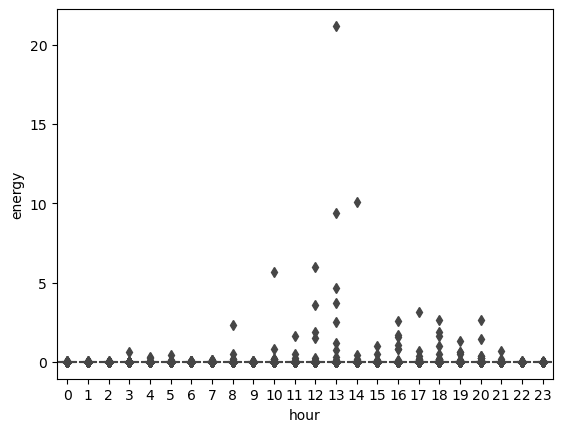

In [67]:
sns.boxplot(data = train, x='hour', y='energy');

In [73]:
train.columns

Index(['timestamp', 'energy', 'hour', 'dayofweek', 'month', 'minute'], dtype='object')

In [77]:
features = ['hour','dayofweek','month','minute']
target = 'energy'

In [78]:
x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [83]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.001)
xgb_reg.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose= 100)

[0]	validation_0-rmse:0.50278	validation_1-rmse:0.54475
[100]	validation_0-rmse:0.45621	validation_1-rmse:0.50233
[200]	validation_0-rmse:0.41419	validation_1-rmse:0.46475
[300]	validation_0-rmse:0.37632	validation_1-rmse:0.43158
[400]	validation_0-rmse:0.34222	validation_1-rmse:0.40242
[500]	validation_0-rmse:0.31151	validation_1-rmse:0.37692
[600]	validation_0-rmse:0.28388	validation_1-rmse:0.35475
[700]	validation_0-rmse:0.25912	validation_1-rmse:0.33554
[800]	validation_0-rmse:0.23692	validation_1-rmse:0.31897
[900]	validation_0-rmse:0.21704	validation_1-rmse:0.30475
[999]	validation_0-rmse:0.19943	validation_1-rmse:0.29272


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

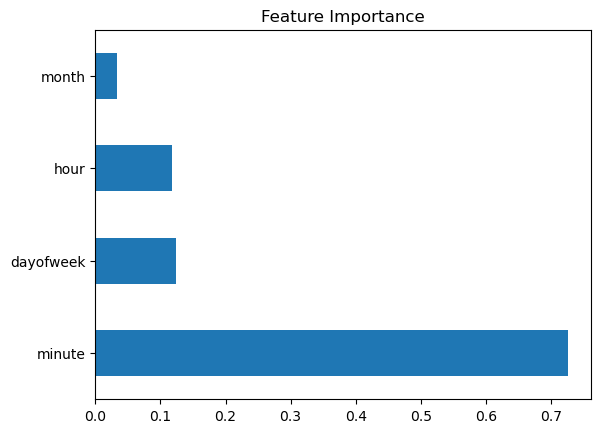

In [88]:
pd.Series(xgb_reg.feature_importances_,index=xgb_reg.feature_names_in_).sort_values(ascending=False)\
.plot(kind='barh',title='Feature Importance');

In [89]:
test['predictions'] = xgb_reg.predict(x_test)

C:\Users\Oluwajuwon\AppData\Local\Temp\ipykernel_11692\1979707022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = xgb_reg.predict(x_test)


In [90]:
test

,timestamp,energy,hour,dayofweek,month,minute,predictions
128868,2022-09-24 03:46:10.399657+00:00,0.001191,3,5,9,46,0.185686
128869,2022-09-24 03:46:45.184630+00:00,0.001174,3,5,9,46,0.185686
128870,2022-09-24 03:47:20.273972+00:00,0.001186,3,5,9,47,0.185686
128871,2022-09-24 03:47:55.547796+00:00,0.001192,3,5,9,47,0.185686
128872,2022-09-24 03:48:31.562127+00:00,0.001234,3,5,9,48,0.185686
...,...,...,...,...,...,...,...
161079,2022-10-22 21:35:34.272836+00:00,0.003651,21,5,10,35,0.186046
161080,2022-10-22 21:36:08.484019+00:00,0.003300,21,5,10,36,0.186046
161081,2022-10-22 21:36:43.545834+00:00,0.003368,21,5,10,36,0.186046
161082,2022-10-22 21:38:28.735422+00:00,0.007590,21,5,10,38,0.186046


In [96]:
test_energy = test.set_index('timestamp')['energy'].copy()
predictions = test.set_index('timestamp')['predictions'].copy()

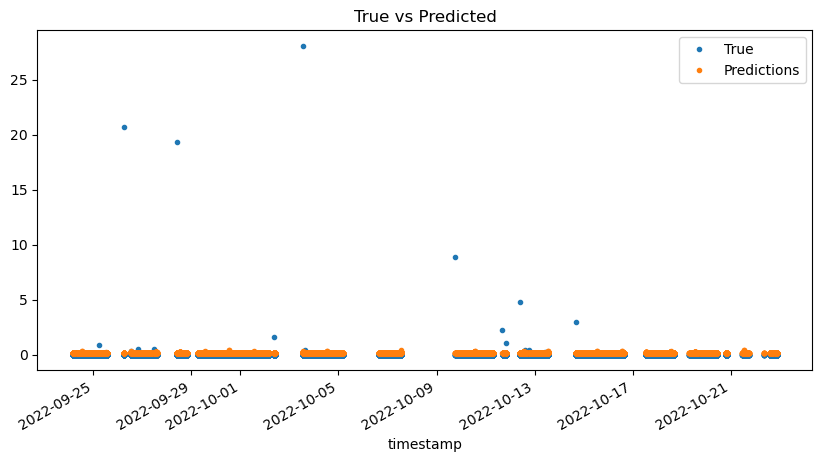

In [101]:
ax = test_energy.plot(style ='.', figsize=(10,5))
predictions.plot(ax=ax, style='.')
plt.legend(['True','Predictions'])
plt.title('True vs Predicted');

In [102]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [104]:
smape(test_energy,predictions)

193.840290709007

In [106]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test_energy,predictions))

0.2927209584462069

In [111]:
np.abs(test_energy - predictions).sort_values(ascending=False)

timestamp
2022-10-03 13:02:47.038115+00:00    27.881089
2022-09-26 05:37:38.091642+00:00    20.478978
2022-09-28 09:46:35.554955+00:00    19.124745
2022-10-09 18:31:50.668615+00:00     8.685217
2022-10-12 09:46:57.649261+00:00     4.573367
                                      ...    
2022-10-22 08:53:01.784489+00:00     0.088289
2022-10-04 14:08:19.938745+00:00     0.064586
2022-09-25 10:20:24.047887+00:00     0.059667
2022-10-13 10:16:37.965328+00:00     0.032807
2022-09-24 07:54:57.338727+00:00     0.029119
Length: 32216, dtype: float64